# Project Name: Bike Rental Count Prediction uisng ML and XGBoost

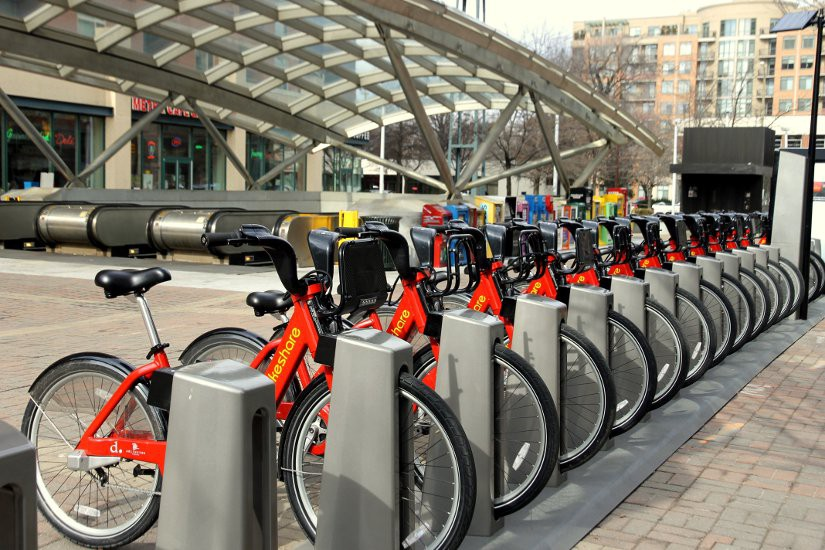

## BackGround:


### Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

### About the Data Set

### Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com.

### The objective of this Case is to Predication of bike rental count on daily based on the environmental and seasonal settings.

## Time Line of the Project:
- Importing Libraries and DataSet
- Data Analysis and Preprocessing
- Feature Engineering
- Model Building using ML
- Model Building and Prediction using XGBoost

## Importing Libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

%matplotlib inline

## Loading the Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/day.csv")


In [ ]:
df.head()

## Understanding the Data Set

### The Data Set contains the following information:
    - instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit :
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

## Data Analysis

In [ ]:
df.shape

In [ ]:
df.dtypes

### Let us rename the colums for a better understanding

In [ ]:
df.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

In [ ]:
df.head()

### Let us convert our Data types of variables to the significant category

In [ ]:
df['datetime']=pd.to_datetime(df.datetime)
df['season']=df.season.astype('category')
df['year']=df.year.astype('category')
df['month']=df.month.astype('category')
df['holiday']=df.holiday.astype('category')
df['weekday']=df.weekday.astype('category')
df['workingday']=df.workingday.astype('category')
df['weather_condition']=df.weather_condition.astype('category')

In [ ]:
df.dtypes

In [ ]:
df.describe()

## Handling Missing Values

In [ ]:
df.isnull().sum()

### Let us see how the different months and seasons affect the rental counts

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month',y='total_count',data=df[['month','total_count','season']],hue='season',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()
#Bar plot for weekday wise monthly distribution of counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='total_count',data=df[['month','total_count','weekday']],hue='weekday',ax=ax1)
ax1.set_title('Weekday wise monthly distribution of counts')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Violin plot for yearly distribution of counts
sns.barplot(x='year',y='total_count',data=df[['year','total_count']])
ax.set_title('Yearly distribution of counts')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.violinplot(data=df,x='holiday',y='total_count',hue='season')
ax.set_title('Holiday wise distribution of counts')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.barplot(data=df,x='holiday',y='total_count',hue='season')
ax.set_title('Holiday wise distribution of counts')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Bar plot for workingday distribution of counts
sns.barplot(data=df,x='workingday',y='total_count',hue='season')
ax.set_title('Workingday wise distribution of counts')
plt.show()

In [ ]:
fig,ax1=plt.subplots(figsize=(15,8))
#Bar plot for weather_condition distribution of counts
sns.barplot(x='weather_condition',y='total_count',data=df[['month','total_count','weather_condition']],ax=ax1)
ax1.set_title('Weather condition wise monthly distribution of counts')
plt.show()

### Outlier Analysis

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=df[['total_count']])
ax.set_title('total_count outliers')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=df[['temp','windspeed','humidity']])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

### Plotting Q-Q Plot

In [ ]:
import scipy.stats as stat
import pylab

In [ ]:
def plot_curve(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

In [ ]:
plot_curve(df,'total_count')

### Co Relation Matrix

In [ ]:
correMtr=df[["temp","atemp","humidity","windspeed","casual","registered","total_count"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

### Data Pre Processing

In [ ]:
#categorical attributes
cat_attributes=['season','holiday','workingday','weather_condition','year']
#numerical attributes
num_attributes=['temp','windspeed','humidity','month','weekday']

### One Hot Encoding

In [ ]:
encoded_df =pd.get_dummies(df,columns=cat_attributes)
print('Shape of transfomed dataframe::',encoded_df.shape)
encoded_df.head()

In [ ]:
encoded_df=encoded_df.drop('datetime',axis=1)

In [ ]:
encoded_df

In [ ]:
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

In [ ]:
x= encoded_df.iloc[:,0:-1] ## Independent Features
y= encoded_df.iloc[:,-1] ## Dependent Varibales

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=42)

In [ ]:
X_train

### Our data is ready for Model Building

## Model Building

### We will be using the following models in our project:
- Linear Regression
- Random Forest Regressor

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linreg= LinearRegression()

In [ ]:
linreg.fit(X_train,y_train)

In [ ]:
pred= linreg.predict(X_test)

In [ ]:
lr=linreg.score(X_train,y_train)
print('Accuracy of the model :',lr)
print('Model coefficients :',linreg.coef_)
print('Model intercept value :',linreg.intercept_)

In [ ]:
#Root mean square error
rmse=math.sqrt(metrics.mean_squared_error(y_test,pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)

In [ ]:
sns.displot(y_test-pred)

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf=RandomForestRegressor(n_estimators=200)

In [ ]:
rf.fit(X_train,y_train)

In [ ]:
rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

In [ ]:
rf_pred=rf.predict(X_test)

In [ ]:
#Root mean square error
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean absolute error :',mae)

**XGBoost **

In [ ]:
# Convert categorical columns to integers
X_train['month'] = X_train['month'].astype(int)
X_train['weekday'] = X_train['weekday'].astype(int)



In [ ]:
# Instantiate the model without categorical support
xgb_model = XGBRegressor()

# Fit the model
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)



In [ ]:
# Evaluate the model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print('XGBoost Root Mean Squared Error (Without Categorical Support):', xgb_rmse)


In [ ]:
# Convert categorical columns to integers
X_train['month'] = X_train['month'].astype(int)
X_train['weekday'] = X_train['weekday'].astype(int)


In [ ]:
# Instantiate the model with categorical support
xgb_model_cat = XGBRegressor(enable_categorical=True)

# Fit the model
xgb_model_cat.fit(X_train, y_train)

# Predictions
xgb_pred_cat = xgb_model_cat.predict(X_test)


In [ ]:
# Evaluate the model
xgb_rmse_cat = np.sqrt(mean_squared_error(y_test, xgb_pred_cat))
print('XGBoost Root Mean Squared Error (With Categorical Support):', xgb_rmse_cat)


In [ ]:
# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Root Mean Squared Error'])



In [ ]:
# Linear Regression
lr_rmse = math.sqrt(metrics.mean_squared_error(y_test, pred))
results_df = results_df.append({'Model': 'Linear Regression', 'Root Mean Squared Error': lr_rmse}, ignore_index=True)



In [ ]:
# Random Forest Regressor
rf_rmse = math.sqrt(metrics.mean_squared_error(y_test, rf_pred))
results_df = results_df.append({'Model': 'Random Forest Regressor', 'Root Mean Squared Error': rf_rmse}, ignore_index=True)



In [ ]:
# Create a list of dictionaries for results
results_data = [
    {'Model': 'Linear Regression', 'Root Mean Squared Error': lr_rmse},
    {'Model': 'Random Forest Regressor', 'Root Mean Squared Error': rf_rmse},
    {'Model': 'XGBoost (Without Categorical Support)', 'Root Mean Squared Error': xgb_rmse},
    {'Model': 'XGBoost (With Categorical Support)', 'Root Mean Squared Error': xgb_rmse_cat},
]

# Create a DataFrame from the list
results_df = pd.DataFrame(results_data)

# Display the results
print(results_df)
